# Hierarchical Bayesian Ranking and World Series Projections

As the title suggests, this post will examine how to use bayesian models for ranking. As I've been on a kick with the MLB statcast data we'll use this technique to create a ranked list of professional baseball teams and project who will win the world series.

# Background

In this section we'll briefly discuss bayesian models and ranking. If you are already familiar with both of these topics you can skip this section.

First, let's cover ranking (in particular ranking with an [item response model](https://en.wikipedia.org/wiki/Item_response_theory)). There are three basic steps to ranking

1. Identify the "items" you wish to rank. This could be any discrete set: baseball teams, baseball players, etc.
2. Fit a model that uses the "item" you wish to rank as a feature to predict something you care about.
3. Extract and use the corresponding model parameters to rank the "items"

For example you might fit a simple linear regression that predicts how much an item will sell for where one of the model's features is the vendor (from a list of several vendors) that is selling the item. After fitting a model you can inspect the coefficient for each vendor. Since these coefficients come from a linear model, a larger coefficient implies a larger predicted selling price. Thus we can use these coefficients to rank the vendors.

Hierarchical Bayesian Ranking then is just a catchy phrase that means parameters from a [hierarchical bayesian model](https://en.wikipedia.org/wiki/Bayesian_hierarchical_modeling) are used to rank the items. One of the advantages of using a bayesian model is that we can include a measure of variance or *uncertainty* in our rankings. Depending on how the model is defined you may also be able to make other interesting inferences from additional model parameters. For example our model that ranks baseball teams can also be used to predict who will win the world series.

# The model

Now that we've covered all the preliminaries we can go over the model

The number of wins for both the away team $team_{1}$ and home team $team_{2}$ are modeled as a [binomial trial](https://en.wikipedia.org/wiki/Binomial_distribution) where $n_{1, 2}$ is the total number of games $team_{1}$ played at $team_{2}$.

\begin{align}
& wins_{1}\sim Binomial(n=n_{1, 2}, p=p_{1}) \\
& wins_{2}\sim Binomial(n=n_{1, 2}, p=p_{2}) \\
\end{align}

Together the probabilities $p_{1}$, $p_{2}$ are [Dirichlet distributed](https://en.wikipedia.org/wiki/Dirichlet_distribution) where the "concentration" parameters are $a_{1} + h_{1}$ and $a_{2}$ which represents the ability of the home team (note that that these team abilties are used to rank the teams later) plus a parameter representing $team_{1}$'s home field advantage (or disadvantage if you are the Mets) and a parameter representing $team_{2}$'s ability as follows

\begin{align}
p\sim Dirichlet(a_{1} + h_{1}, a_{2})
\end{align}

The Dirichlet distribution is a convenient choice because it satisfies the mutually exclusive nature of baseball that only one team can win (there are no ties, except for rare cases). That is $p_{1}+p_{2}=1$. Not only does this prior intuitively fit into our model it helps the model to converge.

While `pymc3` does have a class for the Dirichlet distribution but I couldn't quite get it to work so I simply implemented it in theano.

Some intuition on the choice of the rest of the model's priors is as follows. By the definition of $p_{1}$ and $p_{2}$ the odds that $team_{1}$ will win against $team_{2}$ is $\frac{a_{1}+h_{1}}{a_{2}}$. This relationship has implications on bounds for team ability parameters. 4 or 5 to 1 seems like a reasonable guess of the odds that the best team in baseball will beat the worst team in baseball. If this guess holds then $a_{best}$ should be between 4 and 5  and $a_{worst}$ will be close to 1. We use this insight to partially pool the team abilities and the rest of the model looks like.

\begin{align}
& a_{i}\sim Normal(\mu, \sigma) \\
& h_{i}\sim Normal(0, 1) \\
& \mu\sim Normal(3, 1) \\
& \sigma\sim Uniform(0, 2)
\end{align}

# Fitting the model

The model described above is fit using `pymc3` as follows.

In [5]:
import numpy as np
import pymc3 as pm
import theano
import theano.tensor as T

n_teams = len(df.home_team_id.unique())
n_games = len(df)
n_matchups = np.array([df.total_games, df.total_games]).T
home_team_id = df.home_team_id.as_matrix()
away_team_id = df.away_team_id.as_matrix()
observed_wins = df[['home_team_win', 'away_team_win']]


# we'll update these shared variables later to predict the outcome of the world series
shared_n_matchups = theano.shared(n_matchups)
shared_home_team_id = theano.shared(home_team_id)
shared_away_team_id = theano.shared(away_team_id)


def dirichlet(a):
    # reshaping for broadcasting
    sum_ = T.sum(a, axis=1).reshape((1, -1)).T
    return a / sum_


with pm.Model() as model:
    # priors
    a_mu = pm.Normal('a_mu', 3, 1)
    a_sigma = pm.Uniform('a_sigma', 0, 2)
    
    # team parameters
    team_abilities = pm.Normal('team_abilities', a_mu, a_sigma, shape=n_teams)
    home_field_advantage = pm.Normal('home_field_advantage', 0, 1, shape=n_teams)
    home_team_ability = team_abilities[shared_home_team_id] + home_field_advantage[shared_home_team_id]
    away_team_ability = team_abilities[shared_away_team_id]

    matchups = T.stack([home_team_ability, away_team_ability]).T
    p = pm.Deterministic('p', dirichlet(matchups))
    wins = pm.Binomial('wins', n=shared_n_matchups, p=p, shape=(n_games, 2), observed=observed_wins)

    trace = pm.sample(10_000, model=model)

/Users/dgates/venvs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
/Users/dgates/venvs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [home_field_advantage, team_abilities, a_sigma, a_mu]
Sampling 2 chains: 100%|██████████| 21000/21000 [02:02<00:00, 170.78draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


# Ranking the teams

With the fit model we can rank the MLB teams. One particularly interesting way to look at this is to plot the learned team abilities (ranks) with error ordered by the team ELO scores as calculated by [FiveThirtyEight](https://projects.fivethirtyeight.com/2018-mlb-predictions/).

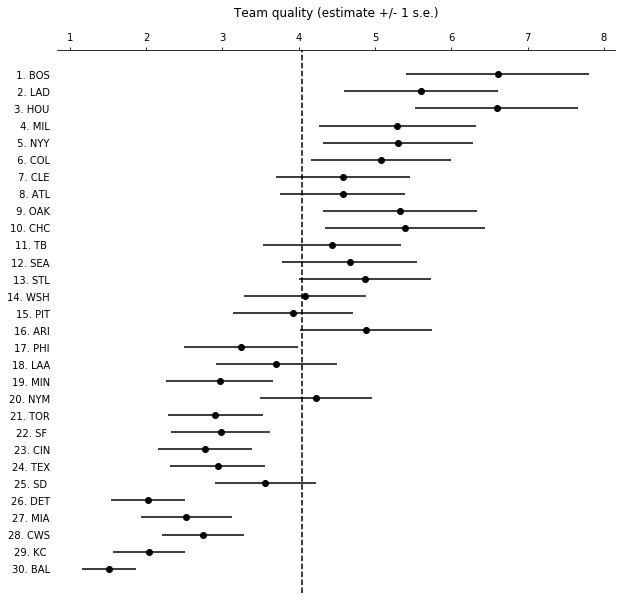

We can also rank teams by Division and League.

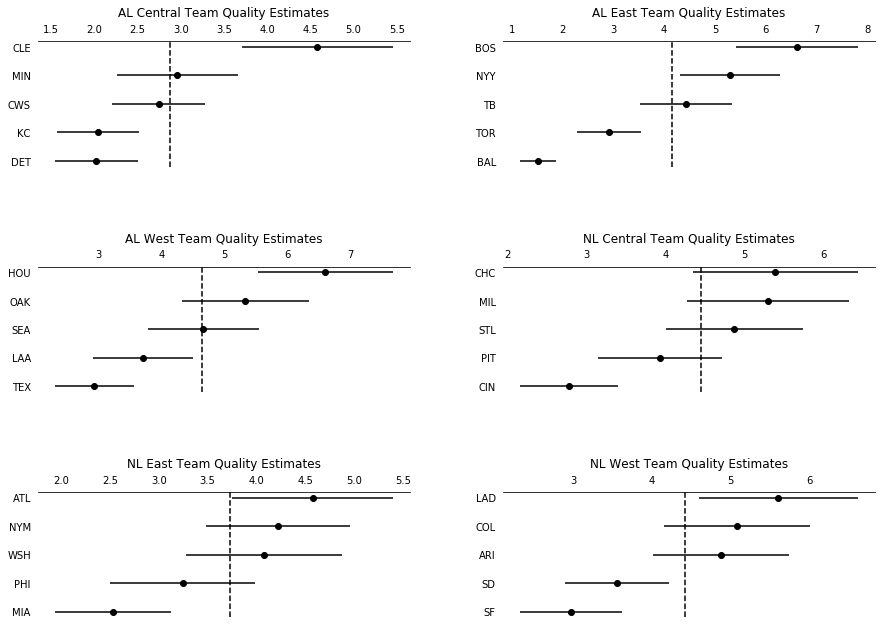

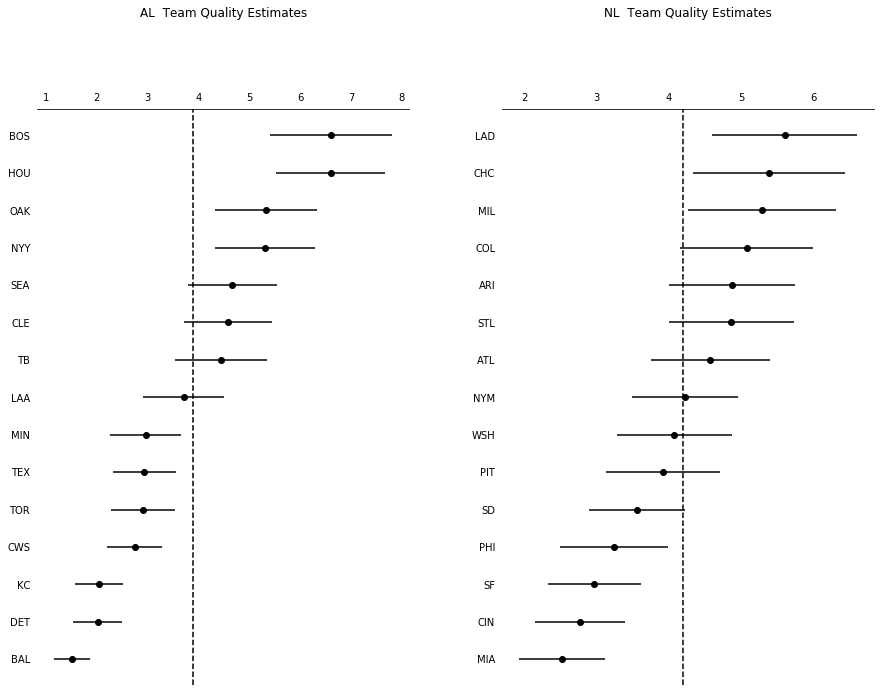

# Likelihood of RedSox winning world series

Finally, we can project the likelihood of the Red Sox winning the world series. With the fit model this is as simple as performing a monte carlo simulation. The steps are as follows (you can find a link to the actual code at the end of this post).

1. For each game in the series sample from the model posterior whether Boston will win.
2. Break when either team reaches four wins.
3. Record the outcome and repeat.

Performing the experiment we obtain a 95% credible region indicating that the probability the Red Sox will win the world series is between 0.54 and 0.73 with the median probability 0.63.

All outcomes of the simulation are shown in the histogram below.

/Users/dgates/venvs/py3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


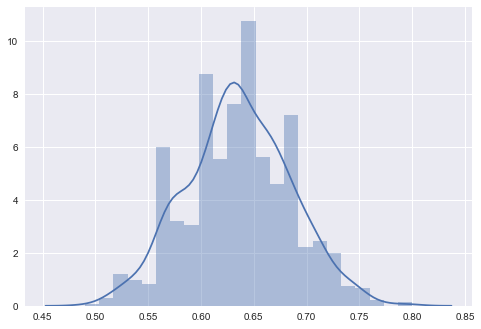

# Acknowledgement and additional resources

This post was particulary inspired by a few of Andrew Gelman's blog posts in which he [ranked world cup teams](https://andrewgelman.com/2014/07/15/stan-world-cup-update/). You can find a Python implementation of his world cup model on my [githup repo](https://github.com/dantegates/world-cup/blob/master/World%20cup.ipynb). The model in this post bears some resemblance to Gelman's world cup model with a few differences noted here

- Gelman models the difference in goals scored by each team in a given game whereas we'll model the number of wins a team earns in a series. Thus our response variables belong to different distributions.
- Gelman uses [FiveThirtyEight](https://fivethirtyeight.com/) soccer rankings in his model as prior. We didn't use rankings in this fashion but we did use FiveThirtyEight's published [Elo](https://en.wikipedia.org/wiki/Elo_rating_system) scores to compare against our learned rankings.

Additionally the data pull and other useful features such as code and evaluations of the model fit were not included in this post to keep it slim. You can find the entire notebook behind this post [here](https://github.com/dantegates/mlb-statcast/blob/master/bayesian-ranking-full.ipynb).